In [2]:
import desitarget 
from desitarget.targets import desi_mask, bgs_mask, mws_mask

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import astropy.units as U

import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [3]:
N = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_N_clustering.dat.fits')
S = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_S_clustering.dat.fits')
data = Table(np.hstack((N, S)))

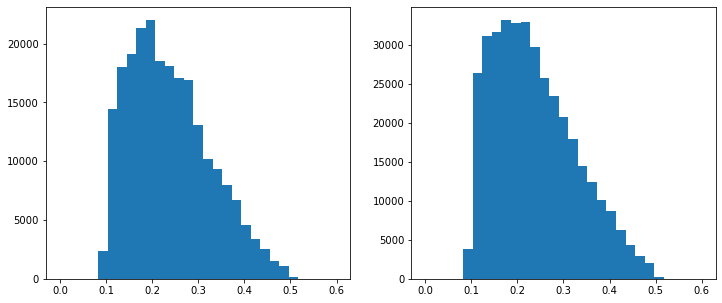

In [4]:
z_bins = np.linspace(0,0.6,30)#np.arange(0,0.61,0.05)
plt.figure(figsize=(12,5))
plt.subplot(121)
count_N = plt.hist(N['Z'], bins=z_bins)
plt.subplot(122)
count_S = plt.hist(S['Z'], bins=z_bins)
plt.show()

In [5]:
number_N = count_N[0] #taget counts in redshift bins size 0.1 from 0.1 <= z <= 0.6
print(np.shape(number_N))
number_N[np.where(number_N==0.0)] = np.nan

number_S = count_S[0] #taget counts in redshift bins size 0.1 from 0.1 <= z <= 0.6
number_S[np.where(number_S==0.0)] = np.nan


(29,)


In [6]:
#code to do this already?

def find_number_density(data, z_b):
    count = plt.hist(data['Z'], bins=z_b)
    number= count[0] #taget counts in redshift bins size 0.1 from 0.1 <= z <= 0.6
    number[np.where(number==0.0)] = np.nan
    
    vol_between = []
    for i, z in enumerate(z_b):
        if i==0:
            continue
        vol_between.append( fsky_hdr*(cosmo.comoving_volume(z_b[i]) - cosmo.comoving_volume(z_b[i-1])).to_value() )

    vol_between = np.array(vol_between)
    number_density = number/vol_between 
    return number_density

In [10]:
sky_area = 4*np.pi*np.rad2deg(1)**2
A = 705.5096+1160.9628
fsky_hdr = A/sky_area
print(fsky_hdr)


cosmo = FlatLambdaCDM(H0=100, Om0=0.3)

0.04524456774666751


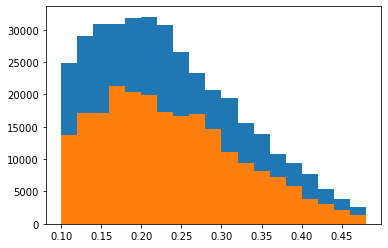

In [11]:
z_bins = np.arange(0.1,0.5,0.02)

n_S = find_number_density(S, z_bins)
n_N = find_number_density(N, z_bins)

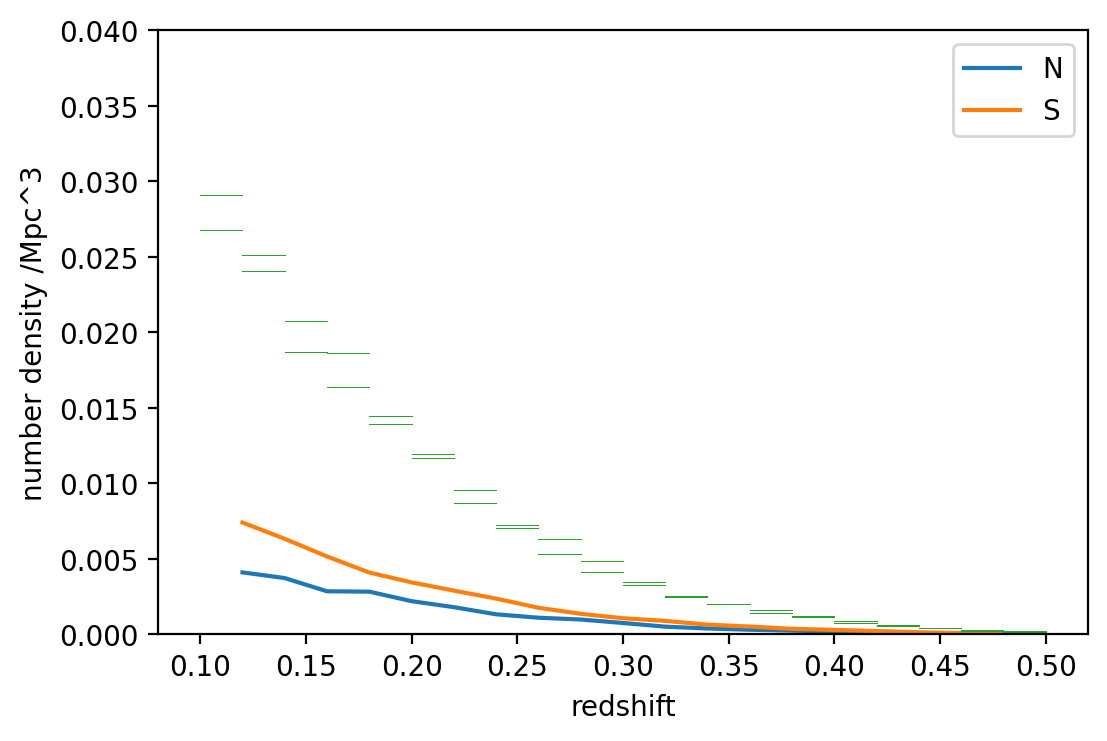

In [12]:
plt.figure(dpi=200)
plt.plot(z_bins[1:], n_N, label='N')
plt.plot(z_bins[1:], n_S, label='S')
plt.xlabel('redshift')
plt.ylabel('number density /Mpc^3')
plt.ylim(0,0.04)
plt.legend()
plt.plot(data['Z'], data['NZ'], lw=0, marker=',')
plt.savefig('../figures/week8-9/da02_number_density.png')
#NZ column much higher

In [13]:
def fkp_model(n,p,comp_fac):
    return 1/(1 + n*p*comp_fac)

In [14]:
print(np.shape(N)[0])
print(np.sum(N['WEIGHT']))

228300
505700.83905514673


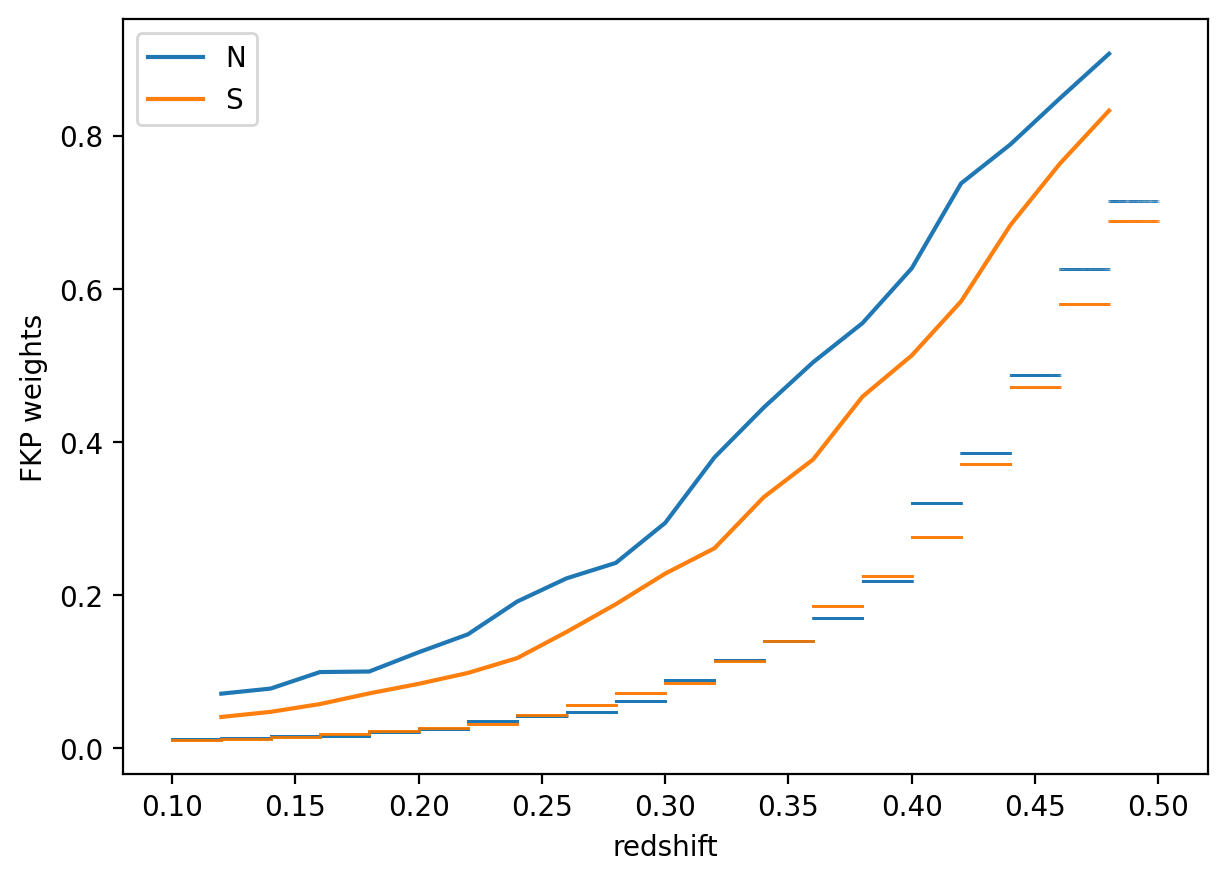

In [15]:
comp_fac_N = np.shape(N)[0]/np.sum(N['WEIGHT'])
comp_fac_S = np.shape(S)[0]/np.sum(S['WEIGHT'])
fkp_model_weights_N = fkp_model(n_N, 7000, comp_fac_N) #suggested:80000 6500000000 80000**2 H0=100:60000
fkp_model_weights_S = fkp_model(n_S, 7000, comp_fac_S) #depends on no of bins - currently 30 (counted apparent no. data bins)

fig, ax = plt.subplots(figsize=(7,5),dpi=200)
plt.plot(z_bins[1:],fkp_model_weights_N, label='N', color='tab:blue')
plt.plot(z_bins[1:],fkp_model_weights_S, label='S', color='tab:orange')
plt.plot(N['Z'], N['WEIGHT_FKP'], lw=0, marker='o', markersize=0.01, color='tab:blue')
plt.plot(S['Z'], S['WEIGHT_FKP'], lw=0, marker='o', markersize=0.01, color='tab:orange')
plt.xlabel('redshift')
plt.ylabel('FKP weights')
#ax.set_yscale('log')
plt.legend()
plt.show()
#N and S different

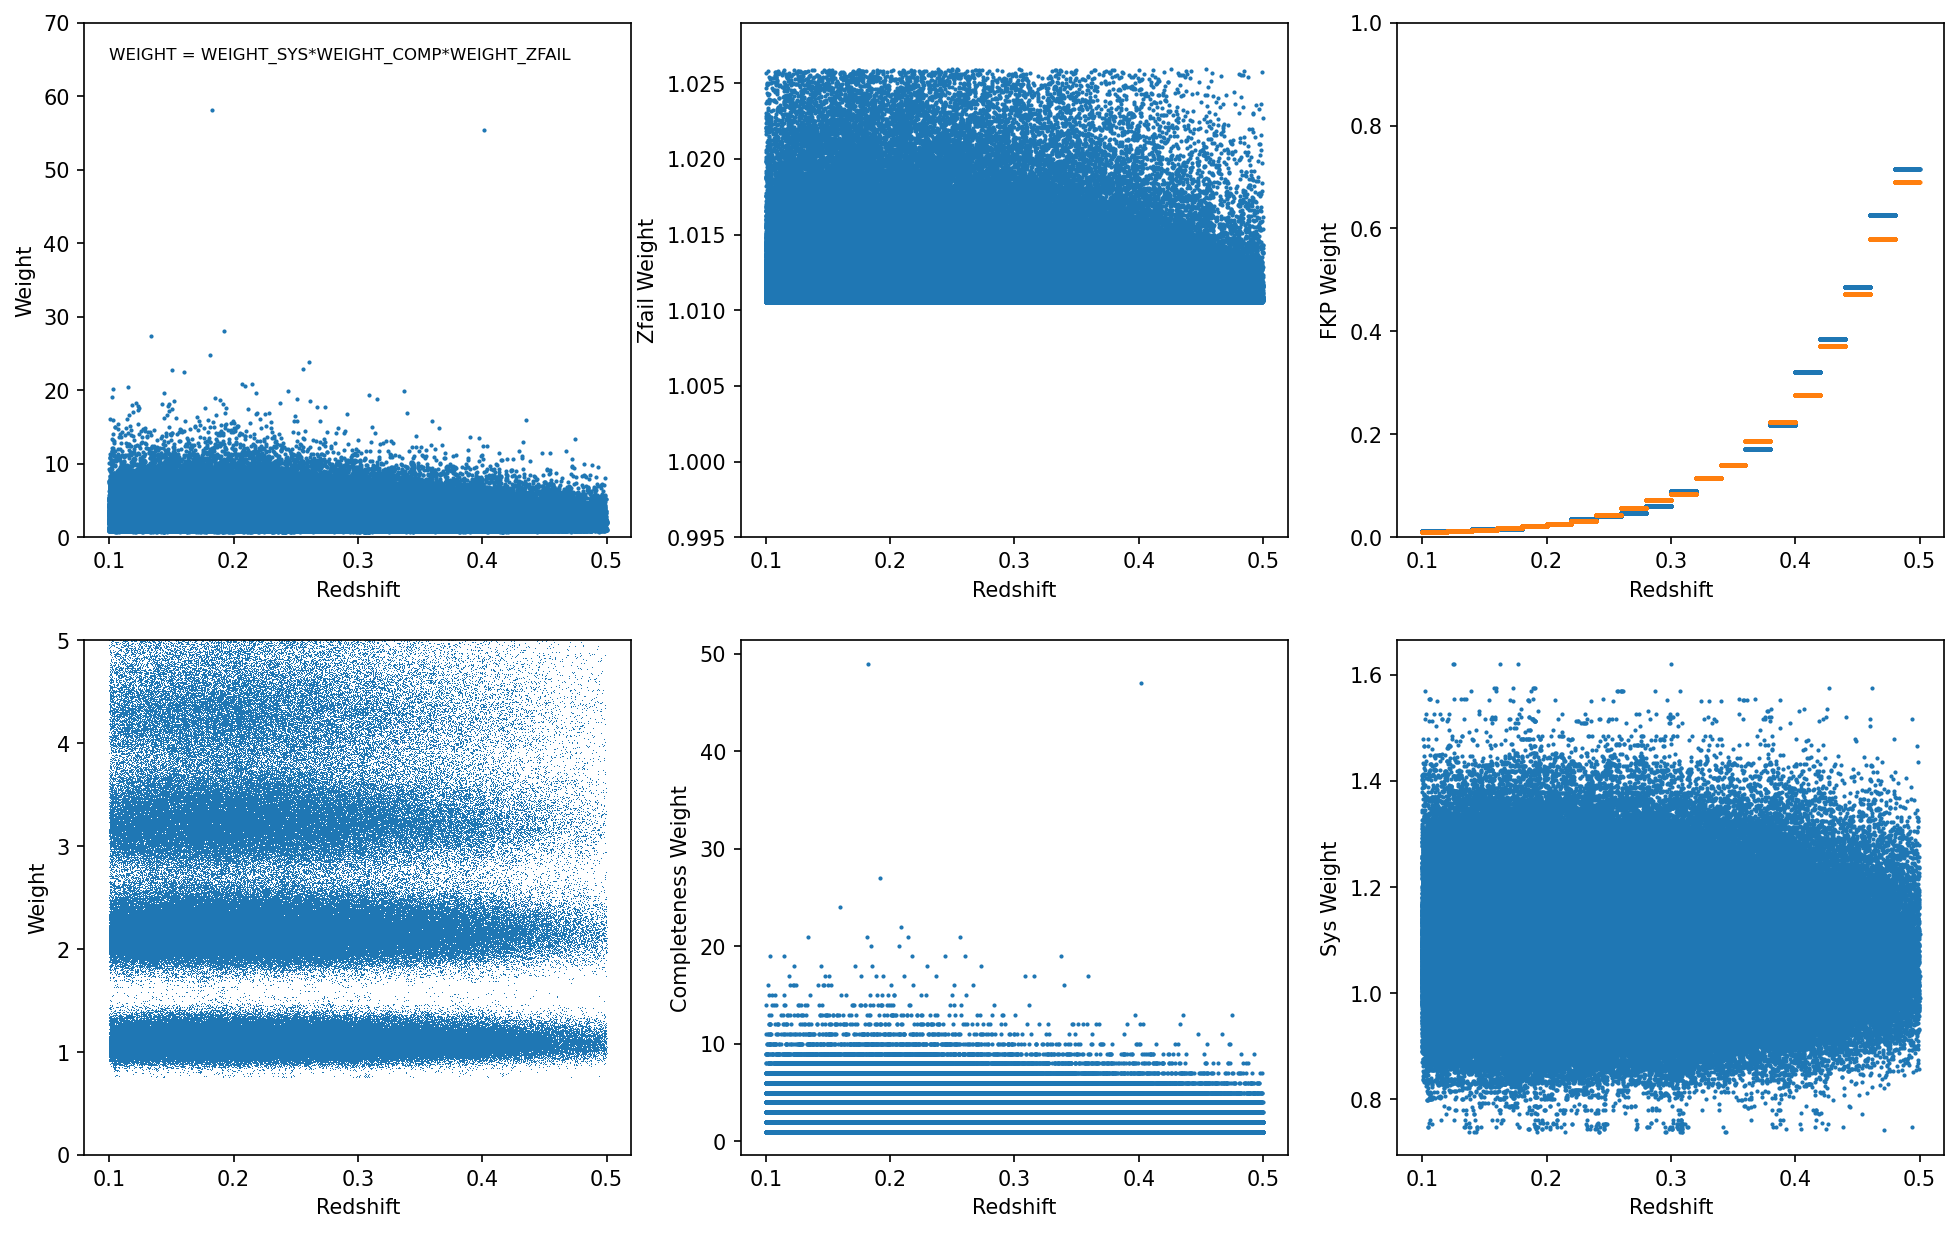

In [16]:
plt.figure(figsize=(16,10),dpi=150)
ax1 = plt.subplot(231)
ax1.plot(data['Z'], data['WEIGHT'], lw=0, marker='o', markersize=1)
plt.text(0.1,65,'WEIGHT = WEIGHT_SYS*WEIGHT_COMP*WEIGHT_ZFAIL', size=8)
plt.xlabel('Redshift')
plt.ylabel('Weight')
plt.ylim(0,70)

ax4 = plt.subplot(234)
ax4.plot(data['Z'], data['WEIGHT'], lw=0, marker=',')
plt.xlabel('Redshift')
plt.ylabel('Weight')
plt.ylim(0,5)

ax2 = plt.subplot(232)
ax2.plot(data['Z'], data['WEIGHT_ZFAIL'], lw=0, marker='o', markersize=1)
plt.xlabel('Redshift')
plt.ylabel('Zfail Weight')
plt.ylim(0.995,1.029)

ax3 = plt.subplot(233)
ax3.plot(N['Z'], N['WEIGHT_FKP'], lw=0, marker='o', markersize=1)
ax3.plot(S['Z'], S['WEIGHT_FKP'], lw=0, marker='o', markersize=1)
plt.xlabel('Redshift')
plt.ylabel('FKP Weight')
plt.ylim(0,1)

ax5 = plt.subplot(235)
ax5.plot(data['Z'], data['WEIGHT_COMP'], lw=0, marker='o', markersize=1)
plt.xlabel('Redshift')
plt.ylabel('Completeness Weight')

ax6 = plt.subplot(236)
ax6.plot(data['Z'], data['WEIGHT_SYS'], lw=0, marker='o', markersize=1)
plt.xlabel('Redshift')
plt.ylabel('Sys Weight')

plt.savefig('../figures/week8-9/da02_weights.png')

#https://desi.lbl.gov/trac/wiki/ClusteringWG/LSScat/DA02main/current_version#Weights
#WEIGHT = WEIGHT_SYS*WEIGHT_COMP*WEIGHT_ZFAIL

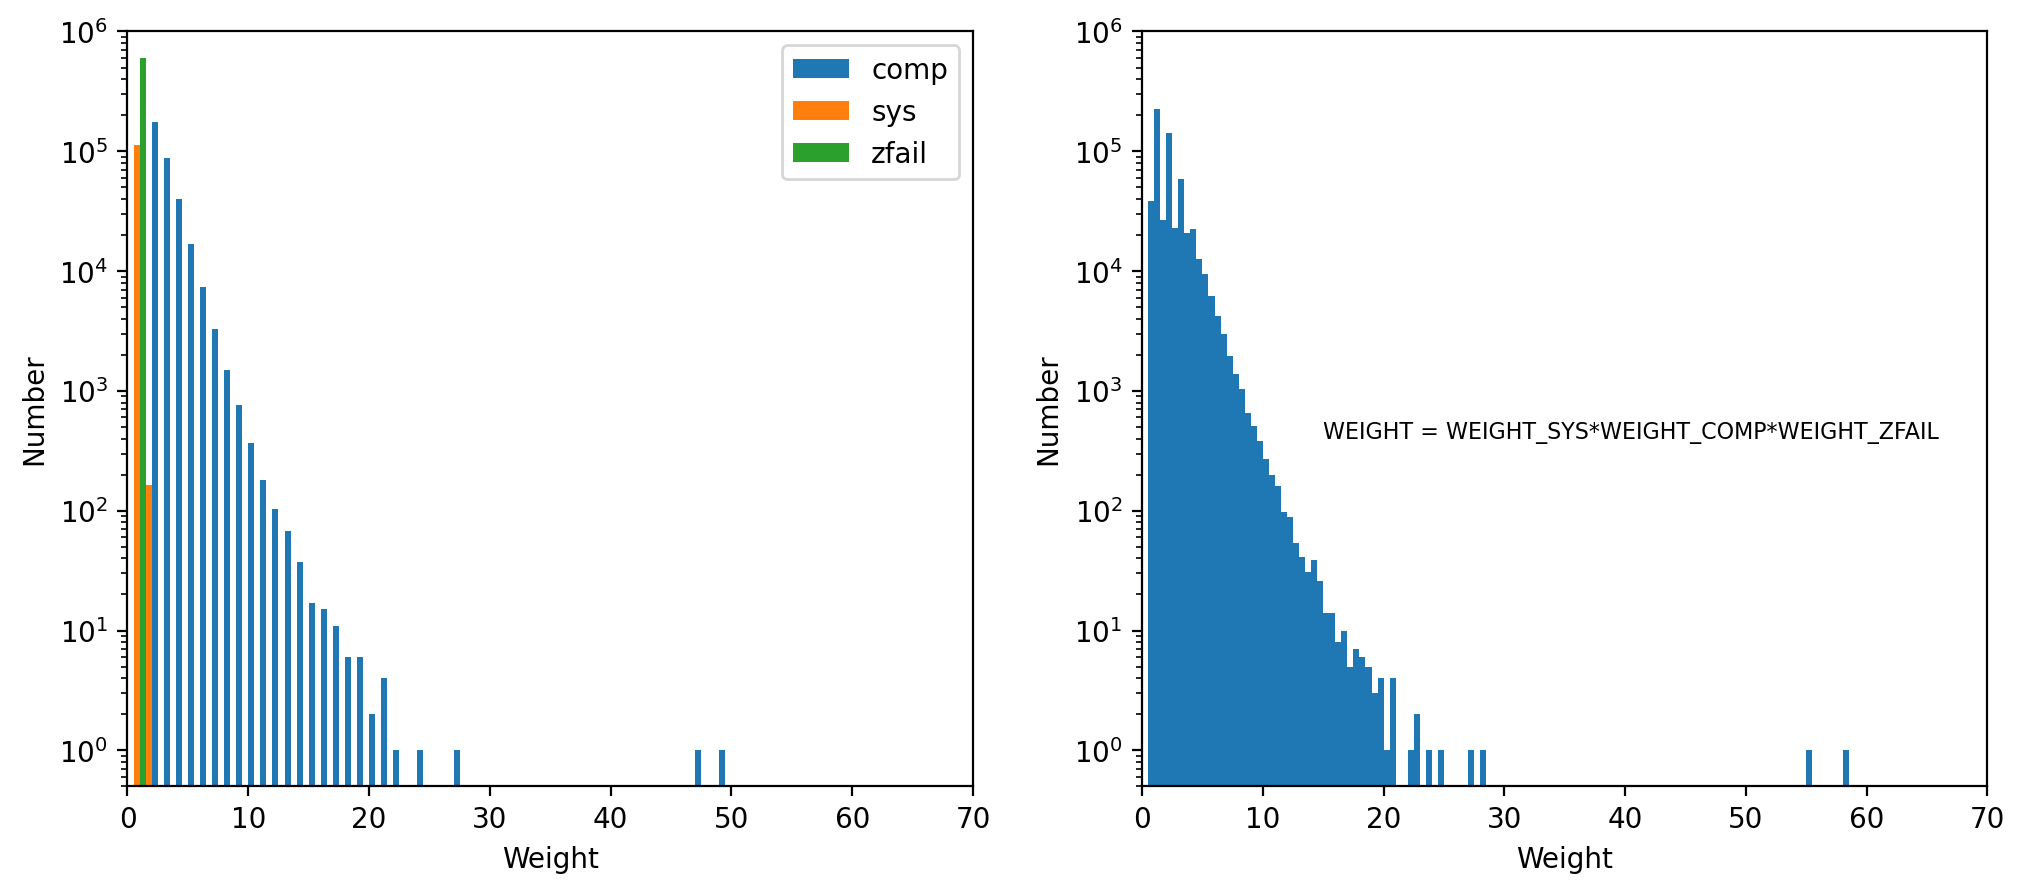

In [17]:
plt.figure(figsize=(12,5), dpi=200)

ax1 = plt.subplot(121)
ax1.hist(data['WEIGHT_COMP'], np.arange(0,70,0.5), label='comp')
ax1.hist(data['WEIGHT_SYS'], np.arange(0,70,0.5), label='sys')
ax1.hist(data['WEIGHT_ZFAIL'], np.arange(0,70,0.5), label='zfail')
ax1.set_yscale('log')
plt.xlabel('Weight')
plt.ylabel('Number')
plt.ylim(0.5,10**6)
plt.xlim(0,70)
plt.legend()

ax2 = plt.subplot(122)
ax2.hist(data['WEIGHT'], np.arange(0,70,0.5))
ax2.set_yscale('log')
plt.xlabel('Weight')
plt.ylabel('Number')
plt.text(15,400,'WEIGHT = WEIGHT_SYS*WEIGHT_COMP*WEIGHT_ZFAIL', size=8)
plt.ylim(0.5,10**6)
plt.xlim(0,70)

plt.savefig('../figures/week8-9/da02_weight_hist.png')